# June 10,13, 2022: model interpretation(s) on simulated data with white noise

In [1]:
import os
import sys
from os.path import join as pjoin

import numpy as np
import pandas as pd
import scipy as sp

import torch
import torch.nn as nn 
print(torch.cuda.is_available())

import pickle, time, random
from tqdm import tqdm
import json
from itertools import combinations, product
from operator import add
import copy
from glob import glob
from sklearn import metrics

from IPython.display import Image

# explanation tools
import captum
from captum.attr import Saliency

# plotting
import matplotlib as mpl
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
plt.rcParamsDefault['font.family'] = "sans-serif"
plt.rcParamsDefault['font.sans-serif'] = "Arial"
plt.rcParams['font.size'] = 14
plt.rcParams["errorbar.capsize"] = 0.5

# nilearn
from nilearn import image
from nilearn import masking
from nilearn import plotting

# main dirs
proj_dir = pjoin(os.environ['HOME'], 'explainable-ai')
results_dir = f"{proj_dir}/results"
month_dir = f"{proj_dir}/nb/jun22"

# folders
sys.path.insert(0, proj_dir)
import helpers.pytorch.dataset_utils as dataset_utils
import helpers.pytorch.model_definitions as model_definitions
import helpers.pytorch.model_helpers as model_helpers
import helpers.pytorch.plot_utils as plot_utils

# cuda device
device = "cuda:1" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

True
Using cuda:1 device


### main (original) data

In [2]:
'''
dataframe
'''
max_data_path = f"{proj_dir}/data/max/data_df.pkl"
with open(max_data_path, 'rb') as f:
    max_data_df = pickle.load(f)

'''
(hyper)-parameters
'''
class ARGS(): pass
args = ARGS()

args.SEED = 74
args.LABELS = [0, 1]
args.names = ['safe', 'threat']
args.MASK = -100

# set random seed
torch.manual_seed(args.SEED)
np.random.seed(args.SEED)

# data
args.num_subjects = len(max_data_df)
args.num_train = round(0.4 * args.num_subjects)
args.num_valid = round(0.3 * args.num_subjects)
args.num_test = args.num_subjects - args.num_train - args.num_valid

'''
generate dataset for the model
'''
subject_idx_list = np.arange(args.num_subjects)
random.Random(args.SEED).shuffle(subject_idx_list)

train_idx_list = subject_idx_list[:args.num_train]
valid_idx_list = subject_idx_list[args.num_train : args.num_train + args.num_valid]
test_idx_list = subject_idx_list[args.num_train + args.num_valid:]

(X_train, y_train) = dataset_utils.get_max_data_trials(args, max_data_df, train_idx_list)
(X_valid, y_valid) = dataset_utils.get_max_data_trials(args, max_data_df, valid_idx_list) 
(X_test, y_test) = dataset_utils.get_max_data_trials(args, max_data_df, test_idx_list)

100%|██████████| 32/32 [00:00<00:00, 7511.21it/s]


### multiple repetitions of noise samples

In [3]:
def collect_fit_out(fit_outputs, fit_out):
    fit_outputs['best_models'] += [fit_out['best_model']]
    fit_outputs['best_epochs'] += [fit_out['best_epoch']]


    H = fit_outputs['histories']
    h = fit_out['history']

    if len(H) == 0:
        for k in h.keys():
            H[k] = np.array([])

    for k in h.keys():
        H[k] = np.vstack([h[k], H[k]]) if H[k].size else h[k]

    # fit_outputs['histories'] = H
        

In [4]:
def single_repetition(noise_level=1.0):
    '''
    data
    '''
    args.noise_level = noise_level
    X_train_, y_train_ = dataset_utils.sim_data_additive_white_noise(args, X_train, y_train)
    X_valid_, y_valid_ = dataset_utils.sim_data_additive_white_noise(args, X_valid, y_valid)
    X_test_, y_test_ = dataset_utils.sim_data_additive_white_noise(args, X_test, y_test)
    # plot_utils.plot_roi_time_series(args, X_train_, y_train_)

    '''
    model
    '''
    args.input_dim = X_train_.shape[-1]
    args.out_dim = len(args.LABELS)
    args.hidden_dim = 8
    args.num_epochs = 75
    args.batch_size = 64
    args.dropout = 0.5

    model = model_definitions.GRU_classifier(args)
    criterion = nn.CrossEntropyLoss(ignore_index=args.MASK, reduction='mean')
    optimizer = torch.optim.Adam(model.parameters())

    model.to(device)
    criterion.to(device)

    data = (
        torch.FloatTensor(X_train_).to(device=device), torch.LongTensor(y_train_).to(device=device),
        torch.FloatTensor(X_valid_).to(device=device), torch.LongTensor(y_valid_).to(device=device),
        torch.FloatTensor(X_test_).to(device=device), torch.LongTensor(y_test_).to(device=device),
    )

    permuts = (
        torch.randperm(X_train_.shape[0]),
        torch.randperm(X_valid_.shape[0]),
        torch.randperm(X_test_.shape[0]),
    )

    fit_out = model_helpers.fit(model, args, data, permuts, criterion, optimizer)

    # print(f"valid: {model_helpers.evaluate(fit_out['best_model'], args, data[2], data[3], criterion, permuts[1])}")
    # print(f"test: {model_helpers.evaluate(fit_out['best_model'], args, data[4], data[5], criterion, permuts[2])}")

    return (data, permuts, criterion, optimizer), fit_out
    

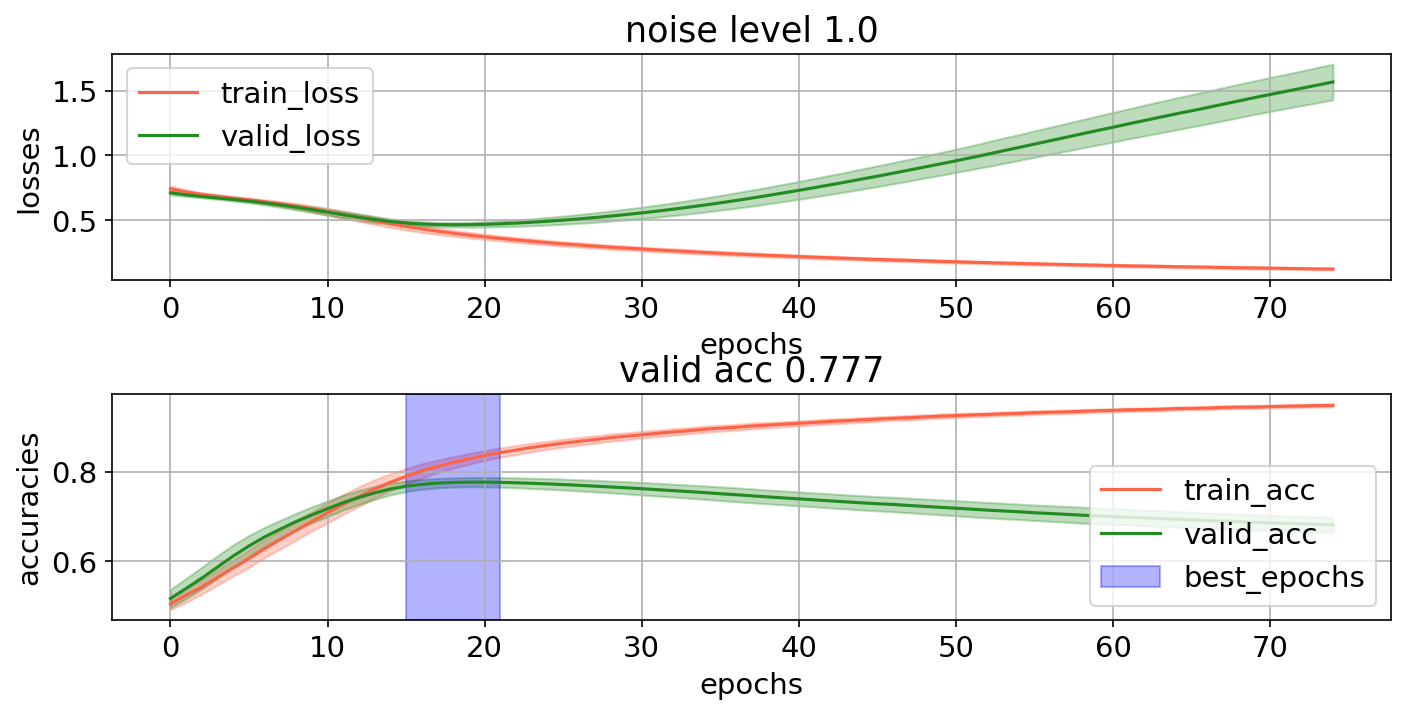

In [5]:
noise_level = 1.0
fig_file = f"{results_dir}/max/sim_data/white_noise/training_curves.png"

if not os.path.exists(fig_file):
    fit_outputs = {
        'best_models': [],
        'histories': {},
        'best_epochs': []
    }
    args.num_repetitions = 50
    for repetition in tqdm(np.arange(args.num_repetitions)):
        _, fit_out = single_repetition(noise_level)
        collect_fit_out(fit_outputs, fit_out)

    model_helpers.plot_training_history(args, fit_outputs, save_fig=True, fig_file=fig_file)

Image(fig_file)

### data and model

In [6]:
(data, permuts, criterion, optimizer), fit_out = single_repetition(noise_level)
model = fit_out['best_model']
print(f"validation loss and acc: {model_helpers.evaluate(model, args, data[2], data[3], criterion, permuts[1])}")

validation loss and acc: (0.4558120444417, 0.7803731113672256)


/home/govindas/venvs/expln-ai3.9/lib/python3.9/site-packages/torch/nn/modules/rnn.py:942: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  ../aten/src/ATen/native/cudnn/RNN.cpp:926.)
  result = _VF.gru(input, hx, self._flat_weights, self.bias, self.num_layers,


### model interpretation(s)

#### saliency

In [7]:
class Softmax_Model(nn.Module):
    def __init__(self, base_model, temperature):
        super(Softmax_Model, self).__init__()

        self.base_model = base_model
        self.temperature = temperature 
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        y = self.base_model(x)
        y = self.softmax(y / self.temperature)
        return y.view(-1, y.shape[-1])

# model for interpretation
args.temperature = 5
sf_model = Softmax_Model(model, args.temperature)
sf_model.to(device)
sf_model.train()

Softmax_Model(
  (base_model): GRU_classifier(
    (gru): GRU(85, 8, batch_first=True)
    (fc): Linear(in_features=8, out_features=2, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (softmax): Softmax(dim=-1)
)

In [8]:
# validation data
X, y = data[2:4] 

# sf_model.zero_grad()

interp_method = Saliency(sf_model)
attribution = interp_method.attribute(X, target=1, abs=False)

/home/govindas/venvs/expln-ai3.9/lib/python3.9/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


In [9]:
inputs = {}
true_attribs = {}
false_attribs = {}
for label in args.LABELS:
    idx = y[:, 0] == label
    inputs[label] = X[idx, :, :]

    attribs = interp_method.attribute(
        inputs=inputs[label],
        target=label,
        abs=False,
    )
    true_attribs[label] = attribs.cpu().numpy()

    attribs = interp_method.attribute(
        inputs=inputs[label],
        target=1-label,
        abs=False,
    )
    false_attribs[label] = attribs.cpu().numpy()

In [10]:
'''
null attributions
'''
args.num_null = 500
def get_hypotheses(label, true_attribs, false_attribs):
    N = true_attribs[label].shape[0]
    # hypotheses
    H1 = np.mean(true_attribs[label], axis=0)

    concat = np.concatenate([true_attribs[label], false_attribs[label]], axis=0)
    H0s = []
    for _ in tqdm(np.arange(args.num_null)):
        np.random.shuffle(concat)
        H0 = np.mean(concat[:N, ...], axis=0)
        H0s.append(H0)

    H0s = np.stack(H0s, axis=0)

    H0_mean = np.mean(H0s, axis=0)
    H0_std = np.std(H0s, axis=0) #/ np.sqrt(N)

    return {'alt': H1, 'null': {'mean': H0_mean, 'std': H0_std}}

hypotheses = {}
for label in args.LABELS:
    hypotheses[label] = get_hypotheses(label, true_attribs, false_attribs)

100%|██████████| 500/500 [00:01<00:00, 487.36it/s]


In [11]:
'''
plot null attributions
'''
def plot_roi_hypotheses(args, hypotheses, savefig=False, fig_file=None):
    H1 = hypotheses['alt'] # time x rois
    H0_m = hypotheses['null']['mean']
    H0_s = hypotheses['null']['std']

    roi_name_file = (
        f"{os.environ['HOME']}/parcellations/MAX_85_ROI_masks/ROI_names.txt"
    )
    roi_names = pd.read_csv(roi_name_file, names=['roi_name']).values.squeeze()

    time = np.arange(H1.shape[0])
    names = ['null', 'alt.']
    colors = {0:'grey', 1:'firebrick'}
    nrows, ncols = 17, 5

    fig, axs = plt.subplots(
        nrows=nrows, 
        ncols=ncols, 
        figsize=(5*ncols, 4*nrows), 
        sharex=False, 
        sharey=True, 
        dpi=150
    )

    plt.subplots_adjust(
        left=None, bottom=None, 
        right=None, top=None, 
        wspace=None, hspace=0.5
    )

    for idx_roi, roi_name in enumerate(roi_names):
        ax = axs[idx_roi//ncols, np.mod(idx_roi,ncols)]

        ax.set_title(f"{roi_name}")
        
        # alt.
        ax.plot(H1[:, idx_roi], color=colors[1], label=names[1])

        # null
        ts_mean = H0_m[:, idx_roi]
        ts_std = H0_s[:, idx_roi]
        ax.plot(ts_mean, color=colors[0], label=names[0])

        ax.fill_between(
            time, 
            (ts_mean - ts_std), 
            (ts_mean + ts_std),
            alpha=0.3, color=colors[0],
        )
        ax.set_xlabel(f"time")
        ax.set_ylabel(f"attribs")
        ax.grid(True)
        ax.legend()

    if savefig:
        fig.savefig(
            fig_file,
            dpi=150,
            format='png',
            bbox_inches='tight',
            transparent=False
        )

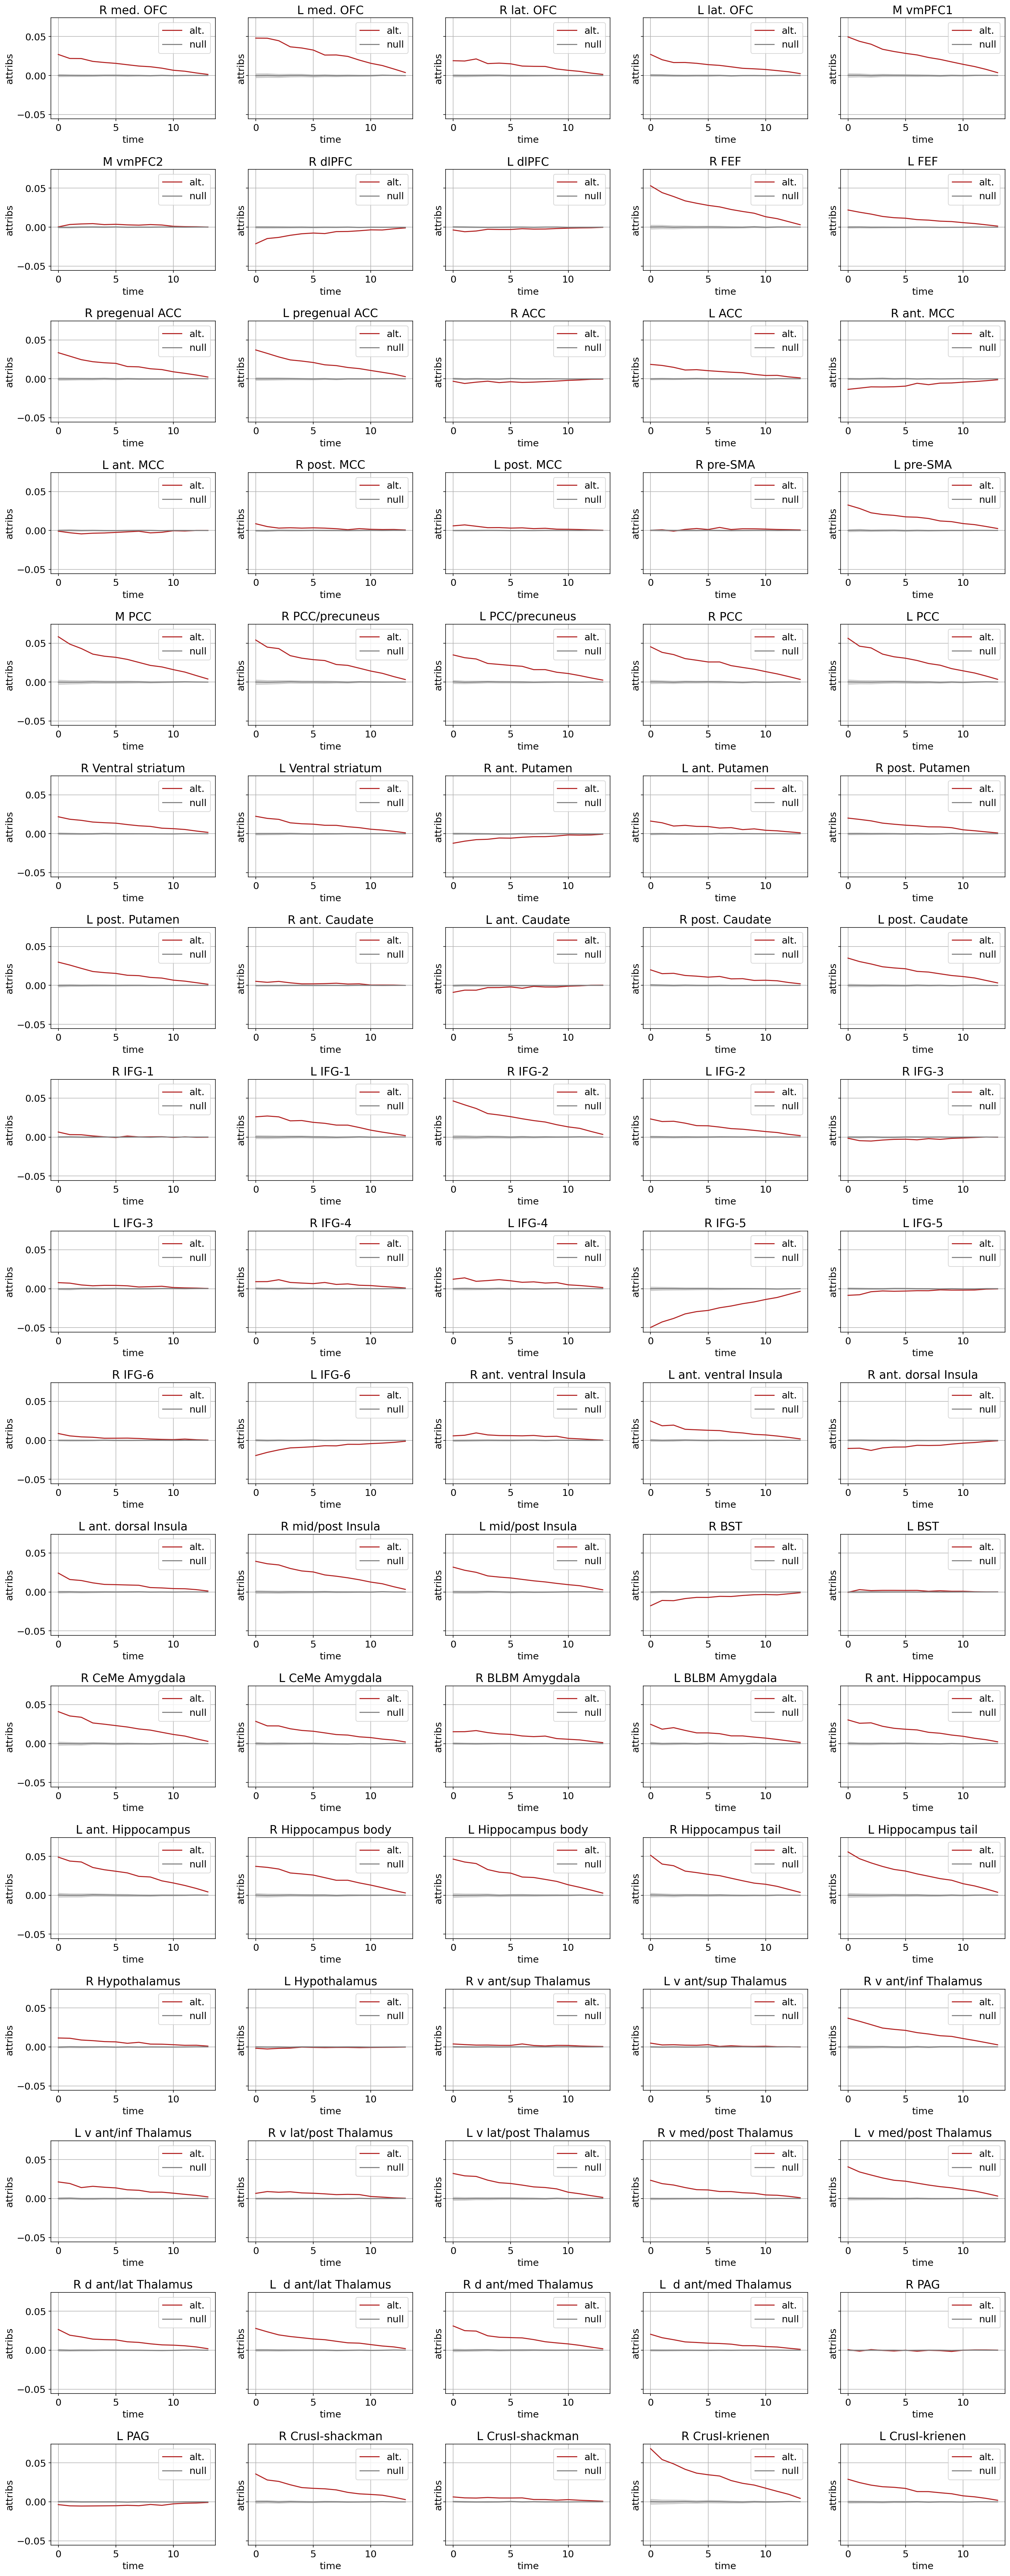

In [12]:
label = 0
plot_roi_hypotheses(args, hypotheses[label])

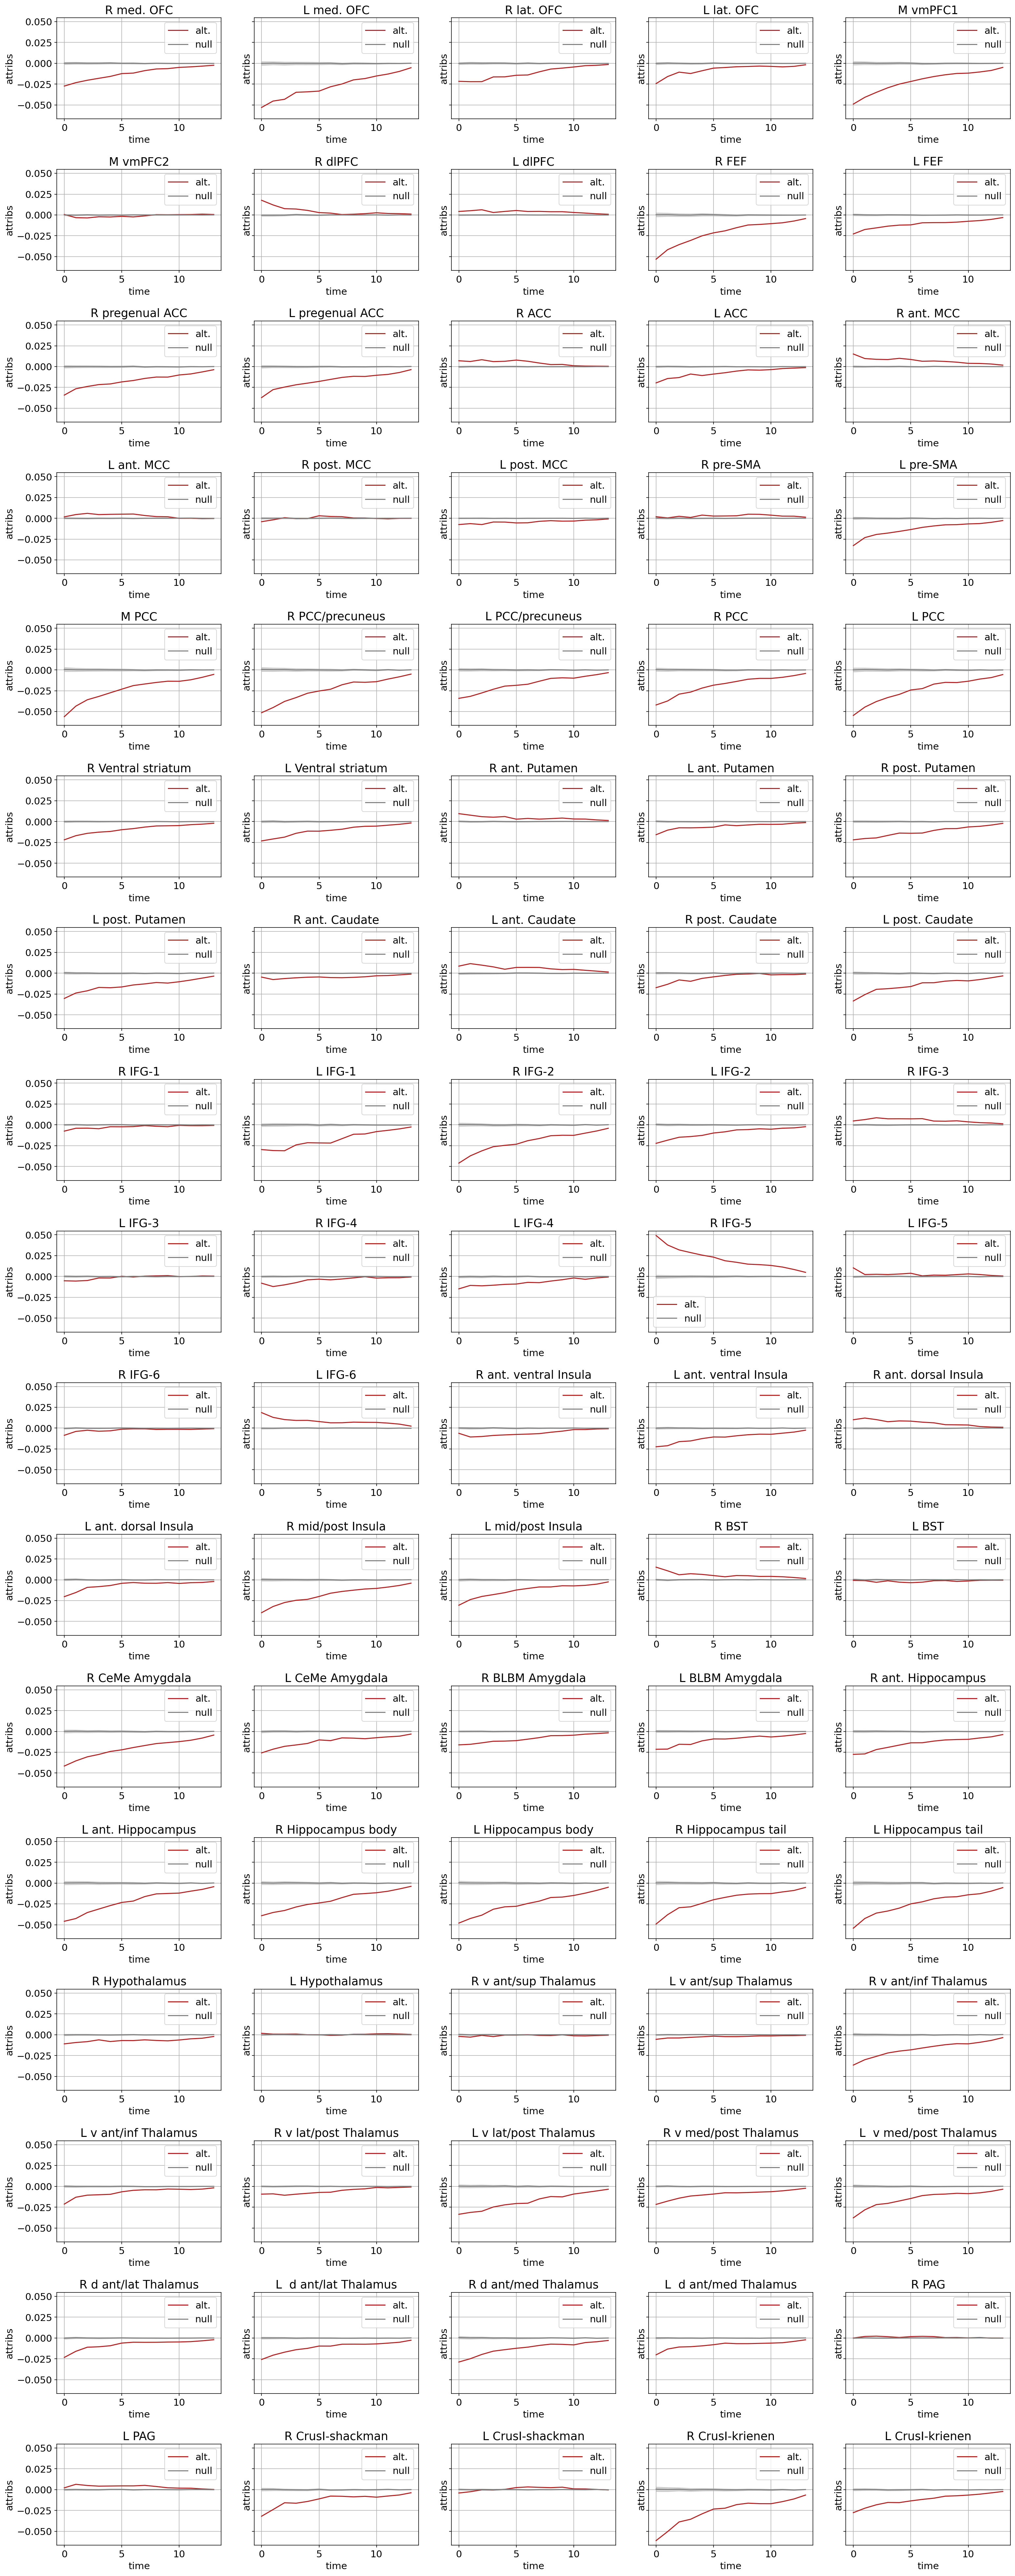

In [13]:
label = 1
plot_roi_hypotheses(args, hypotheses[label])